In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Load data from Google Drive
df_A = pd.read_csv('/content/gdrive/MyDrive/CSE8803_Team2/Classification/Stress/Datasets/F_Relax_A_feature.csv', header=0)
df_M = pd.read_csv('/content/gdrive/MyDrive/CSE8803_Team2/Classification/Stress/Datasets/F_Relax_M_feature.csv', header=0)
df_S = pd.read_csv('/content/gdrive/MyDrive/CSE8803_Team2/Classification/Stress/Datasets/F_Relax_S_feature.csv', header=0)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Fill missing values with the mode
df_A = df_A.fillna(df_A.mode().iloc[0])
df_M = df_M.fillna(df_M.mode().iloc[0])
df_S = df_S.fillna(df_S.mode().iloc[0])




In [ ]:
print(df_A.shape)
print(df_M.shape)
print(df_S.shape)

(6000, 450)
(6000, 450)
(6000, 450)


In [ ]:
# Drop the first column
df_A = df_A.iloc[:, 1:]
df_M = df_M.iloc[:, 1:]
df_S = df_S.iloc[:, 1:]

In [ ]:
print(df_A.shape)
print(df_M.shape)
print(df_S.shape)

(6000, 449)
(6000, 449)
(6000, 449)


In [ ]:
# Perform feature selection and dimensionality reduction
def perform_feature_selection(df: pd.DataFrame, variance_threshold: float):
    y = df.iloc[:, -1]  # Target variable is the last column
    kept_columns_rfe = []  # List to store selected features
    start_column_index = 0

    for i in range(32):
        # Selecting features, excluding ratios (e.g., theta-beta ratio)
        X = df.iloc[:, list(range(start_column_index, start_column_index + 5)) + list(range(start_column_index + 8, start_column_index + 14))]
        curr_columns = X.columns

        # Recursive Feature Elimination with Cross Validation (RFECV)
        rfecv = RFECV(estimator=LogisticRegression(max_iter=10000), min_features_to_select=1, cv=StratifiedKFold(), scoring='accuracy')
        rfecv.fit(X, y)

        # Track the kept features
        kept_columns_rfe.extend(curr_columns[rfecv.support_])
        start_column_index += 14

    # After RFE, get the remaining features
    df_after_rfe = df[kept_columns_rfe]

    # Scaling and PCA for dimensionality reduction
    scaler = StandardScaler()  # Scale the features
    scaled_X = scaler.fit_transform(df_after_rfe)

    # Reduce to a certain percentage of explained variance (e.g., 80%)
    pca = PCA(n_components=0.80)  # Adjust as needed
    pca_result = pca.fit_transform(scaled_X)

    return pca_result, y  # Return PCA-transformed features and target labels



In [ ]:
# Apply feature selection and dimensionality reduction to the datasets
X_A, y_A = perform_feature_selection(df_A, variance_threshold=0.8)
X_M, y_M = perform_feature_selection(df_M, variance_threshold=0.8)
X_S, y_S = perform_feature_selection(df_S, variance_threshold=0.8)


In [ ]:
# Train-test split (80-20)
def split_data(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_A_train, X_A_test, y_A_train, y_A_test = split_data(X_A, y_A)
X_M_train, X_M_test, y_M_train, y_M_test = split_data(X_M, y_M)
X_S_train, X_S_test, y_S_train, y_S_test = split_data(X_S, y_S)

# Hyperparameter tuning with GridSearchCV and evaluation
def tune_and_evaluate_model(X_train, y_train, X_test, y_test, dataset_name):
    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    grid_search = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=StratifiedKFold(), scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"Results for {dataset_name}:")
    print("Best Parameters:", grid_search.best_params_)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))

    # ROC Curve
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()



Results for F_Relax_A:
Best Parameters: {'C': 0.01}
[[333 267]
 [191 409]]
              precision    recall  f1-score   support

           0       0.64      0.56      0.59       600
           1       0.61      0.68      0.64       600

    accuracy                           0.62      1200
   macro avg       0.62      0.62      0.62      1200
weighted avg       0.62      0.62      0.62      1200

Accuracy: 0.6183333333333333


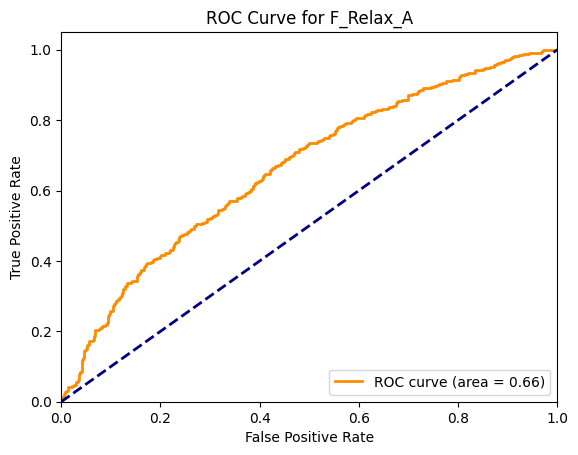

Results for F_Relax_M:
Best Parameters: {'C': 0.01}
[[338 262]
 [211 389]]
              precision    recall  f1-score   support

           0       0.62      0.56      0.59       600
           1       0.60      0.65      0.62       600

    accuracy                           0.61      1200
   macro avg       0.61      0.61      0.61      1200
weighted avg       0.61      0.61      0.61      1200

Accuracy: 0.6058333333333333


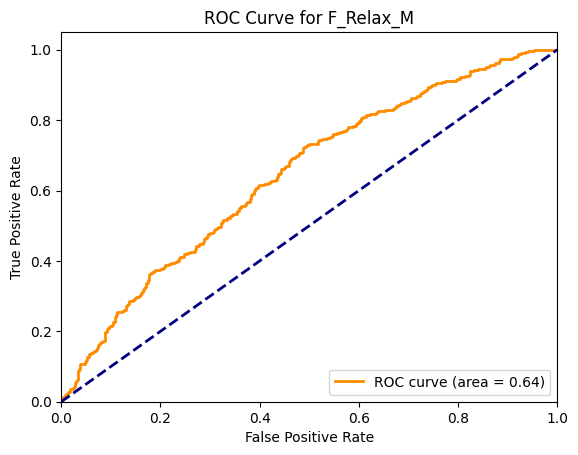

Results for F_Relax_S:
Best Parameters: {'C': 0.1}
[[372 228]
 [205 395]]
              precision    recall  f1-score   support

           0       0.64      0.62      0.63       600
           1       0.63      0.66      0.65       600

    accuracy                           0.64      1200
   macro avg       0.64      0.64      0.64      1200
weighted avg       0.64      0.64      0.64      1200

Accuracy: 0.6391666666666667


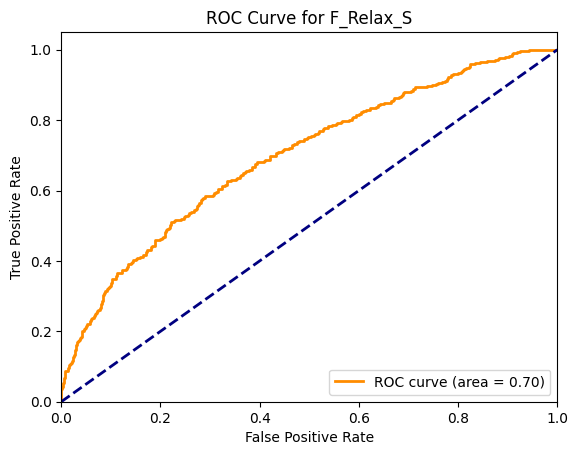

In [ ]:
# Evaluate on all datasets
tune_and_evaluate_model(X_A_train, y_A_train, X_A_test, y_A_test, "F_Relax_A")
tune_and_evaluate_model(X_M_train, y_M_train, X_M_test, y_M_test, "F_Relax_M")
tune_and_evaluate_model(X_S_train, y_S_train, X_S_test, y_S_test, "F_Relax_S")